# Baselines

Here we collect baseline runs, that allow us to track out progress. In particular this allows us to validate performance after refactoring. 

In the baseline (onehot_mlp_graph_2, onehot_mlp_graph, onehot_mlp) versions, we had an error in the train / test set split, which lead to overestimations in accuracy. These only differ in implementation, but all represent one-hot encoded features with mlp model. 

Starting with onehot_mlp_graph_3 we fixed the train / test split. Therefore performance appears slightly reduced for this model.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = f'../../data/training/baselines/train'
merged_folder = f'../../data/training/baselines/merged'

plot_folder = f'plots/baseline'

make_dir(plot_folder)
make_dir(merged_folder)

In [3]:
file_names = ['metrics.parquet']

def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

In [4]:
metrics_df['baseline'].value_counts(dropna=False)

onehot_mlp_graph_2    18000
onehot_mlp_graph_3    18000
onehot_mlp_graph      18000
onehot_mlp            10000
Name: baseline, dtype: int64

## Overview

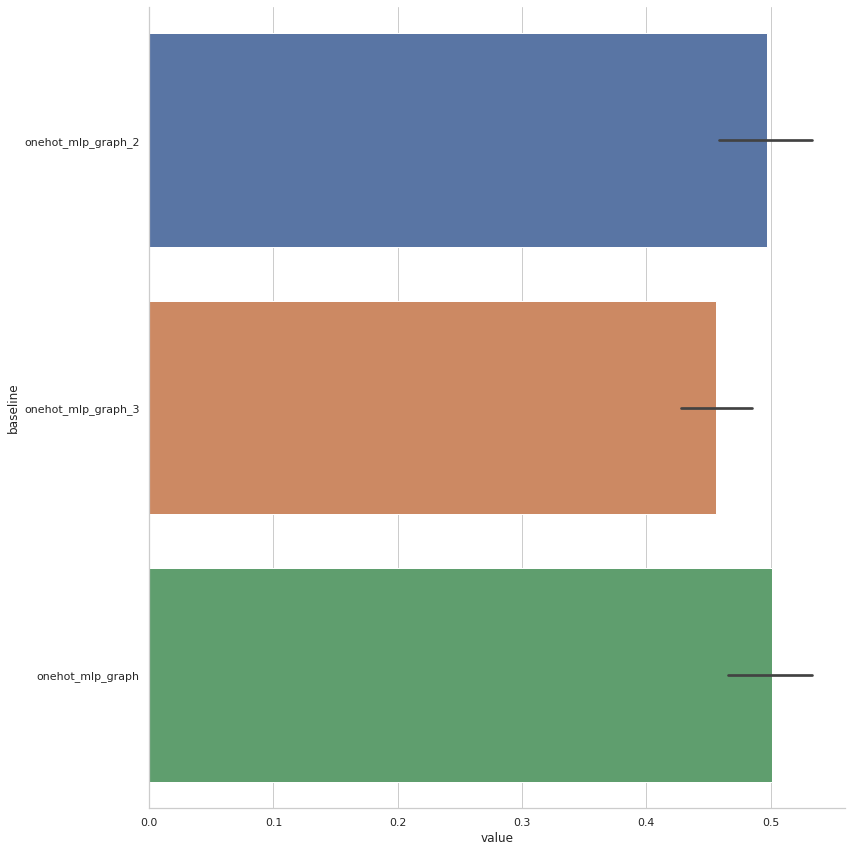

In [5]:
metric_name = 'accuracy'

w = (
    (metrics_df['name'] == metric_name) &
    (metrics_df['set'] == 'test') & 
    (metrics_df['strategy'] == 'greedy') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]
sns.set_style("whitegrid")
# df['y_ordinal'] = df['y_ordinal'].astype(str)
sns.catplot(data=df, x='value', y='baseline', orient='h', kind='bar', sharex=False, height=12)
